## Shortlist Promising Models - Random Forest Classifier

#### 0. Import modules and define parameters

In [1]:
import sys
sys.path.append("..")

from module.utils import general_utils
from module.utils import data_prepare_utils
import module.utils.bin_class_utils as bin_class_utils
from sklearn.pipeline import Pipeline
import time
import pandas as pd

In [2]:
start = time.time()

In [3]:
TRAIN_FILE_PATH = "../data/train_df.csv"
VALIDATION_FILE_PATH = "../data/validation_df.csv"

TARGET_ATTR = "label"
TARGET_TYPE = "binary"

ESTIMATOR_NAME = "RandomForestClassifier"

SAMPLE_SIZE = 0.2
SAMPLE_RANDOM_STATE = 24
TARGET_ENCODING_RANDOM_STATE = 42
MODEL_RANDOM_STATE = 42
PERMUTATION_IMPORTANCE_RANDOM_STATE = 0

ATTRS_TO_DROP = ['uid', 'app_score', 'his_on_shelf_time', 'task_id', 'spread_app_id', 'tags', 'dev_id']

CVS_SCORING_LIST = ['accuracy', 'precision', 'recall', 'f1']
PERMUTATION_SCORING_LIST = ['average_precision', 'roc_auc']
PERM_DROP_THRESHOLD_PERCENT = 0.15

#### 1. Import Data

In [4]:
train_df = general_utils.read_csv(TRAIN_FILE_PATH)


Read CSV file ../data/train_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1920544,3854,3367,7,207,17,5,11,13,37,...,4,20,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0
1,1850503,3903,6370,7,173,52,5,12,69,11,...,2,-1,-1,-1,2,5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^...,12,50,7,0
2,2157496,1847,6428,6,178,17,5,18,70,39,...,7,20,1,-1,9,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,7,0
3,2072043,4125,4468,7,168,37,5,12,44,40,...,2,20,-1,-1,2,6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,11,17,6,0
4,1084626,4811,3326,7,183,29,5,12,86,37,...,3,18,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0


df.shape: (670513, 36)


#### 2. Sample smaller training sets for fast exploration

In [5]:
train_df_sample = data_prepare_utils.sample_data(train_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del train_df


Sample 0.2 fraction from DataFrame:
sample_df.shape: (134103, 36)


#### 3. Check attribute types

In [6]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_df_sample.columns if attr not in numerical_attr_list and attr != TARGET_ATTR]
attr_list = numerical_attr_list + categorical_attr_list
attr_list

['uid',
 'task_id',
 'adv_id',
 'creat_type_cd',
 'adv_prim_id',
 'dev_id',
 'inter_type_cd',
 'slot_id',
 'spread_app_id',
 'tags',
 'app_first_class',
 'app_second_class',
 'age',
 'city',
 'city_rank',
 'device_name',
 'device_size',
 'career',
 'gender',
 'net_type',
 'residence',
 'his_app_size',
 'his_on_shelf_time',
 'app_score',
 'emui_dev',
 'list_time',
 'device_price',
 'up_life_duration',
 'up_membership_grade',
 'membership_life_duration',
 'consume_purchase',
 'communication_onlinerate',
 'communication_avgonline_30d',
 'indu_name',
 'pt_d']

#### 4. Predefined data processing strategy in prep.ipynb

In [7]:
train_df_sample = data_prepare_utils.drop_duplicate_obs(train_df_sample)


Drop duplicate observations:
df.shape:  (134103, 36)
drop_dup_df.shape:  (133982, 36)


In [8]:
preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, ATTRS_TO_DROP, TARGET_TYPE, TARGET_ENCODING_RANDOM_STATE)
preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('column_dropper',
                                                  DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                        'app_score',
                                                                                        'his_on_shelf_time',
                                                                                        'task_id',
                                                                                        'spread_app_id',
                                                                                        'tags',
                                                                                        'dev_id'])),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 []),
                                ('categorical',
                                 Pipeline(steps=[('column_dropper',
                                                  DropColumnsTransformer(attrs_to_drop=['...
                                  'adv_prim_id', 'dev_id', 'inter_type_cd',
                                  'slot_id', 'spread_app_id', 'tags',
                                  'app_first_class', 'app_second_class', 'age',
                                  'city', 'city_rank', 'device_name',
                                  'device_size', 'career', 'gender', 'net_type',
                                  'residence', 'his_app_size',
                                  'his_on_shelf_time', 'app_score', 'emui_dev',
                                  'list_time', 'device_price',
                                  'up_life_duration', 'up_membership_grade',
                                  'membership_life_duration', ...])])

#### 5. Define default model

In [9]:
estimator = bin_class_utils.get_default_model(ESTIMATOR_NAME, MODEL_RANDOM_STATE)
estimator

RandomForestClassifier(class_weight='balanced', random_state=42)

#### 6. Define composite model

In [10]:
composite_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('estimator', estimator)
])
composite_estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                                         'app_score',
                                                                                                         'his_on_shelf_time',
                                                                                                         'task_id',
                                                                                                         'spread_app_id',
                                                                                                         'tags',
                                                                                                         'dev_id'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropCol...
                                                   'app_second_class', 'age',
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [11]:
train_cap_x_df, train_y_df = train_df_sample.drop(columns=TARGET_ATTR), train_df_sample[[TARGET_ATTR]]
del train_df_sample

In [12]:
composite_estimator.fit(
    train_cap_x_df,
    train_y_df.values.ravel()
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                                         'app_score',
                                                                                                         'his_on_shelf_time',
                                                                                                         'task_id',
                                                                                                         'spread_app_id',
                                                                                                         'tags',
                                                                                                         'dev_id'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropCol...
                                                   'app_second_class', 'age',
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

#### 7. Evaluate model performance on train set

Evaluate the trained estimator performance on train sample set
Check accuracy score
train sample set accuracy score: 0.965644638832082

Check classification report
{'0': {'precision': 0.965660366090358, 'recall': 0.9999768087261033, 'f1-score': 0.982519036135427, 'support': 129359.0}, '1': {'precision': 0.8846153846153846, 'recall': 0.004975124378109453, 'f1-score': 0.009894600989460099, 'support': 4623.0}, 'accuracy': 0.965644638832082, 'macro avg': {'precision': 0.9251378753528713, 'recall': 0.5024759665521064, 'f1-score': 0.49620681856244353, 'support': 133982.0}, 'weighted avg': {'precision': 0.9628639385899563, 'recall': 0.965644638832082, 'f1-score': 0.9489589850563283, 'support': 133982.0}}

Check confusion matrix
train sample set confusion matrix: 
[[129356      3]
 [  4600     23]]
True Positives =  129356
True Negatives =  23
False Positives(Type I error) =  3
False Negatives(Type II error) =  4600

Check cross validation score

accuracy scores: [0.96544389 0.96548121 0.96555

/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



precision scores: [0.4        0.         0.66666667 0.33333333 0.33333333]
np.mean(scores): 0.3467
np.std(scores, ddof=1): 0.2376

recall scores: [0.00216216 0.         0.0021645  0.00108225 0.00108108]
np.mean(scores): 0.0013
np.std(scores, ddof=1): 0.0009

f1 scores: [0.00430108 0.         0.00431499 0.0021575  0.00215517]
np.mean(scores): 0.0026
np.std(scores, ddof=1): 0.0018

Check the ROC Curve and AUC


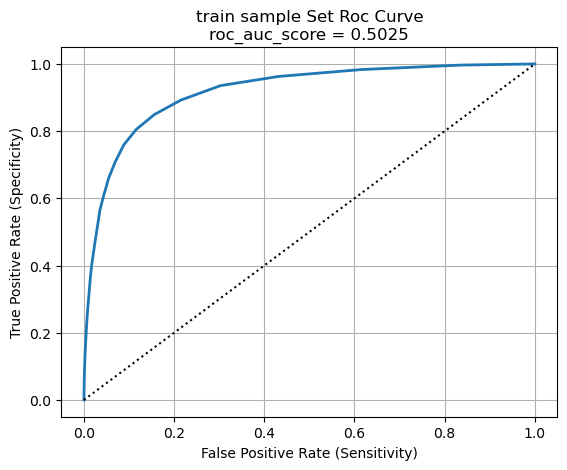


Check Precision-Recall Curve and Average Precision Score


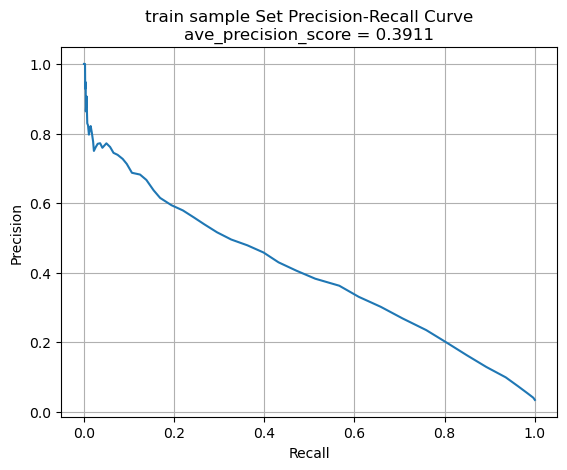

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,train sample,0.9656,0.884615,0.004975,0.9655,0.3467,0.0013,0.0026,0.5025


In [13]:
eval_train_results = bin_class_utils.eval_class(train_cap_x_df, train_y_df, composite_estimator, "train sample", CVS_SCORING_LIST)
eval_train_results

#### 8. Read in and sample validation data set

In [14]:
validation_df = general_utils.read_csv(VALIDATION_FILE_PATH)


Read CSV file ../data/validation_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1451378,2082,3033,7,154,56,5,11,31,40,...,4,20,-1,-1,7,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,17,5,0
1,1619957,1225,4676,7,178,17,5,17,70,39,...,4,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,6,0
2,1698084,2206,2822,7,177,56,5,14,31,40,...,5,20,1,-1,2,-1,-1,17,3,0
3,1983802,5103,2564,7,151,60,4,12,23,26,...,4,20,-1,-1,8,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,39,5,0
4,1537560,1098,1732,7,134,55,4,17,65,18,...,4,20,-1,-1,2,3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20...,12,14,1,0


df.shape: (167629, 36)


In [15]:
validation_df_sample = data_prepare_utils.sample_data(validation_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del validation_df


Sample 0.2 fraction from DataFrame:
sample_df.shape: (33525, 36)


In [16]:
validation_cap_x_df, validation_y_df = validation_df_sample.drop(columns=TARGET_ATTR), validation_df_sample[[TARGET_ATTR]]
del validation_df_sample

#### 9. Evaluate model performance on validation set

Evaluate the trained estimator performance on validation sample set
Check accuracy score
validation sample set accuracy score: 0.9656375838926174

Check classification report
{'0': {'precision': 0.9656612667442346, 'recall': 0.9999691062436281, 'f1-score': 0.9825157843613403, 'support': 32369.0}, '1': {'precision': 0.8333333333333334, 'recall': 0.004325259515570935, 'f1-score': 0.008605851979345956, 'support': 1156.0}, 'accuracy': 0.9656375838926174, 'macro avg': {'precision': 0.899497300038784, 'recall': 0.5021471828795995, 'f1-score': 0.49556081817034314, 'support': 33525.0}, 'weighted avg': {'precision': 0.9610983706659944, 'recall': 0.9656375838926174, 'f1-score': 0.9489336849777883, 'support': 33525.0}}

Check confusion matrix
validation sample set confusion matrix: 
[[32368     1]
 [ 1151     5]]
True Positives =  32368
True Negatives =  5
False Positives(Type I error) =  1
False Negatives(Type II error) =  1151

Check cross validation score

accuracy scores: [0.96569724 0.965548

/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



precision scores: [0.66666667 0.         0.         0.         0.        ]
np.mean(scores): 0.1333
np.std(scores, ddof=1): 0.2981

recall scores: [0.00865801 0.         0.         0.         0.        ]
np.mean(scores): 0.0017
np.std(scores, ddof=1): 0.0039

f1 scores: [0.01709402 0.         0.         0.         0.        ]
np.mean(scores): 0.0034
np.std(scores, ddof=1): 0.0076

Check the ROC Curve and AUC


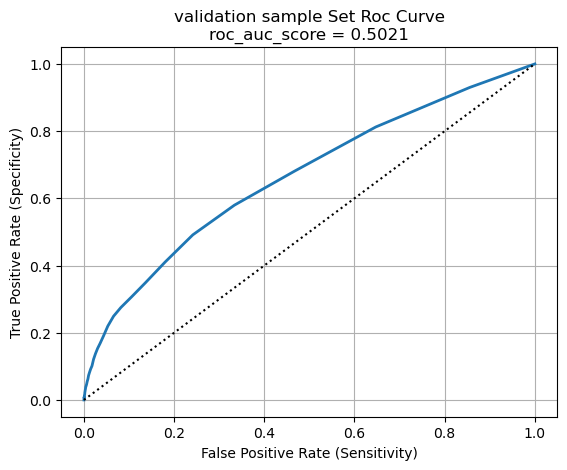


Check Precision-Recall Curve and Average Precision Score


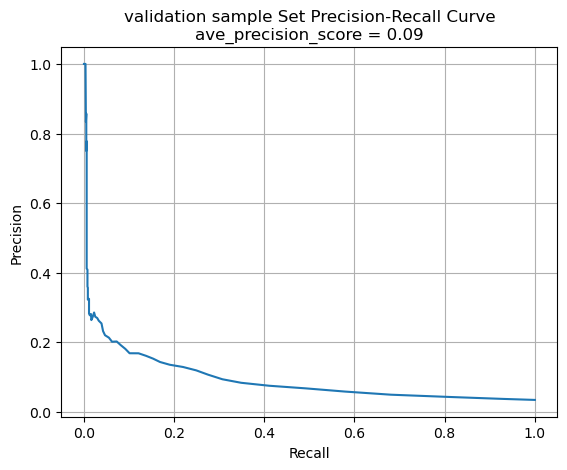

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,validation sample,0.9656,0.833333,0.004325,0.9655,0.1333,0.0017,0.0034,0.5021


In [17]:
eval_validation_results = bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, composite_estimator, "validation sample", CVS_SCORING_LIST)
eval_validation_results

#### 10. Check the most significant attributes

In [18]:
perm_results_df = bin_class_utils.check_out_permutation_importance(
    composite_estimator, 
    train_cap_x_df, 
    train_y_df, 
    PERMUTATION_IMPORTANCE_RANDOM_STATE,
    PERMUTATION_SCORING_LIST
)
perm_results_df


Check out permutation importance:


,metric_name,feature_name,metric_mean,metric_std_dev
0,average_precision,adv_id,0.218420,0.003740
1,average_precision,slot_id,0.207453,0.004109
2,average_precision,age,0.139255,0.002333
3,average_precision,adv_prim_id,0.129304,0.004174
4,average_precision,device_name,0.097855,0.002307
5,average_precision,career,0.094860,0.002013
6,average_precision,his_app_size,0.091076,0.003060
7,average_precision,list_time,0.069913,0.002469
8,average_precision,residence,0.069176,0.002431
9,average_precision,city,0.068589,0.002436


#### 11. Feature selection and engineering

In [19]:
common_least_important_attrs = bin_class_utils.drop_least_important_attrs(perm_results_df, PERM_DROP_THRESHOLD_PERCENT)
common_least_important_attrs

['creat_type_cd',
 'up_membership_grade',
 'membership_life_duration',
 'net_type',
 'consume_purchase',
 'app_first_class',
 'gender',
 'inter_type_cd']

#### 12. Fit and evaluate again

In [20]:
attrs_to_drop_exp = list(set(ATTRS_TO_DROP + common_least_important_attrs))
attrs_to_drop_exp

['app_score',
 'tags',
 'creat_type_cd',
 'uid',
 'task_id',
 'up_membership_grade',
 'membership_life_duration',
 'net_type',
 'consume_purchase',
 'app_first_class',
 'spread_app_id',
 'his_on_shelf_time',
 'gender',
 'dev_id',
 'inter_type_cd']

In [21]:
preprocessor_exp = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, attrs_to_drop_exp, TARGET_TYPE, TARGET_ENCODING_RANDOM_STATE)

estimator_exp = bin_class_utils.get_default_model(ESTIMATOR_NAME, MODEL_RANDOM_STATE)

composite_estimator_exp = Pipeline(steps=[
    ('preprocessor', preprocessor_exp), 
    ('estimator', estimator_exp)
])

In [22]:
composite_estimator_exp.fit(
    train_cap_x_df,
    train_y_df.values.ravel()
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['app_score',
                                                                                                         'tags',
                                                                                                         'creat_type_cd',
                                                                                                         'uid',
                                                                                                         'task_id',
                                                                                                         'up_membership_grade',
                                                                                                         'membership_life_duration',
                                                                                                         'net_type',
                                                                                                         'consume_purchase',
                                                                                                         'app_first_class',
                                                                                                         'spread_app_id',
                                                                                                         'his_on_shelf_time',
                                                                                                         'gender',
                                                                                                         'dev_id'...
                                                   'app_second_class', 'age',
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

Evaluate the trained estimator performance on train sample exp set
Check accuracy score
train sample exp set accuracy score: 0.9656595662103865

Check classification report
{'0': {'precision': 0.9656608787829021, 'recall': 0.9999922695753678, 'f1-score': 0.9825267643182932, 'support': 129359.0}, '1': {'precision': 0.9583333333333334, 'recall': 0.004975124378109453, 'f1-score': 0.009898859479233914, 'support': 4623.0}, 'accuracy': 0.9656595662103865, 'macro avg': {'precision': 0.9619971060581177, 'recall': 0.5024836969767387, 'f1-score': 0.4962128118987636, 'support': 133982.0}, 'weighted avg': {'precision': 0.9654080445020781, 'recall': 0.9656595662103865, 'f1-score': 0.9489665935187009, 'support': 133982.0}}

Check confusion matrix
train sample exp set confusion matrix: 
[[129358      1]
 [  4600     23]]
True Positives =  129358
True Negatives =  23
False Positives(Type I error) =  1
False Negatives(Type II error) =  4600

Check cross validation score

accuracy scores: [0.96555585 0.

/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



precision scores: [1.         0.         0.5        0.33333333 0.33333333]
np.mean(scores): 0.4333
np.std(scores, ddof=1): 0.3651

recall scores: [0.00216216 0.         0.00108225 0.00108225 0.00108108]
np.mean(scores): 0.0011
np.std(scores, ddof=1): 0.0008

f1 scores: [0.00431499 0.         0.00215983 0.0021575  0.00215517]
np.mean(scores): 0.0022
np.std(scores, ddof=1): 0.0015

Check the ROC Curve and AUC


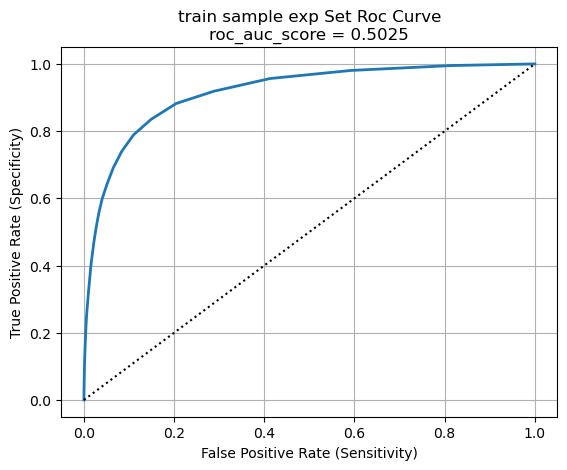


Check Precision-Recall Curve and Average Precision Score


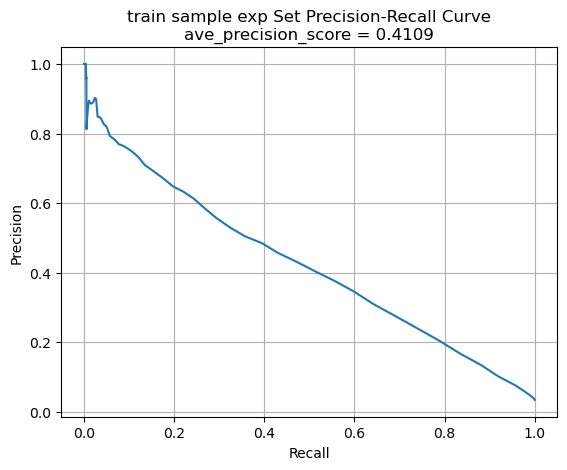

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,train sample exp,0.9657,0.958333,0.004975,0.9655,0.4333,0.0011,0.0022,0.5025


In [23]:
eval_train_exp_results = bin_class_utils.eval_class(train_cap_x_df, train_y_df, composite_estimator_exp, "train sample exp", CVS_SCORING_LIST)
eval_train_exp_results

Evaluate the trained estimator performance on validation sample exp set
Check accuracy score
validation sample exp set accuracy score: 0.9656674123788218

Check classification report
{'0': {'precision': 0.9656622911694511, 'recall': 1.0, 'f1-score': 0.9825312267601573, 'support': 32369.0}, '1': {'precision': 1.0, 'recall': 0.004325259515570935, 'f1-score': 0.008613264427217916, 'support': 1156.0}, 'accuracy': 0.9656674123788218, 'macro avg': {'precision': 0.9828311455847256, 'recall': 0.5021626297577855, 'f1-score': 0.49557224559368757, 'support': 33525.0}, 'weighted avg': {'precision': 0.9668463147759572, 'recall': 0.9656674123788218, 'f1-score': 0.9489488504900042, 'support': 33525.0}}

Check confusion matrix
validation sample exp set confusion matrix: 
[[32369     0]
 [ 1151     5]]
True Positives =  32369
True Negatives =  5
False Positives(Type I error) =  0
False Negatives(Type II error) =  1151

Check cross validation score

accuracy scores: [0.9655481  0.9655481  0.96539896 0.9

/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.


precision scores: [0. 0. 0. 0. 0.]
np.mean(scores): 0.0000
np.std(scores, ddof=1): 0.0000

recall scores: [0. 0. 0. 0. 0.]
np.mean(scores): 0.0000
np.std(scores, ddof=1): 0.0000

f1 scores: [0. 0. 0. 0. 0.]
np.mean(scores): 0.0000
np.std(scores, ddof=1): 0.0000

Check the ROC Curve and AUC


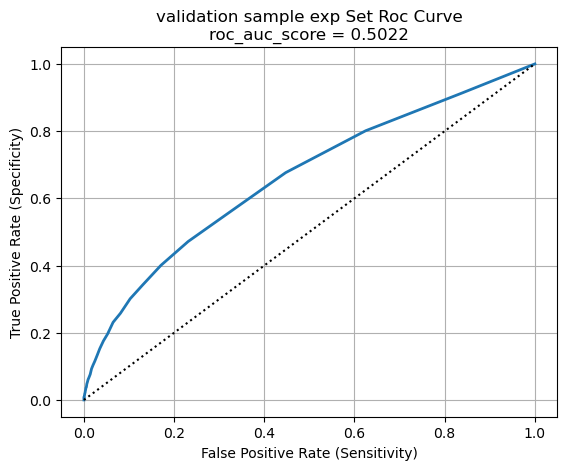


Check Precision-Recall Curve and Average Precision Score


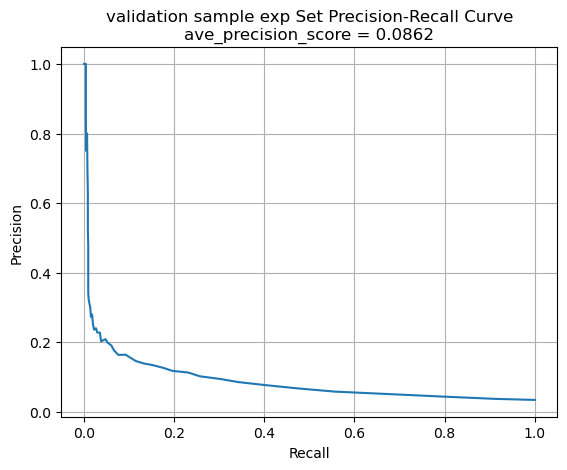

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,validation sample exp,0.9657,1.0,0.004325,0.9655,0.0,0.0,0.0,0.5022


In [24]:
eval_validation_exp_results = bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, composite_estimator_exp, "validation sample exp", CVS_SCORING_LIST)
eval_validation_exp_results

#### 13. Decide attrs to drop for fine-tuning

In [25]:
compare_df = pd.concat([eval_train_results, eval_validation_results, eval_train_exp_results, eval_validation_exp_results], axis=0)
compare_df

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,train sample,0.9656,0.884615,0.004975,0.9655,0.3467,0.0013,0.0026,0.5025
0,validation sample,0.9656,0.833333,0.004325,0.9655,0.1333,0.0017,0.0034,0.5021
0,train sample exp,0.9657,0.958333,0.004975,0.9655,0.4333,0.0011,0.0022,0.5025
0,validation sample exp,0.9657,1.000000,0.004325,0.9655,0.0000,0.0000,0.0000,0.5022


- The model performances before and after dropping some common least important features in permutation importance test are similar. 
- `accuracy scores`, `roc_auc_score`, and the mean of `precision scores` in cross validation are very close.
- `precision score` and `recall score` for class 1 show slight improvements.
- `false positives (Type I error)` increases slightly after dropping attributes.
- Because dropping attributes doesn't significantly decrease the performance, we would apply the new drop list in the fine-tuning stage.

In [26]:
attrs_to_drop_for_fine_tuning = attrs_to_drop_exp

attrs_to_drop_for_fine_tuning

['app_score',
 'tags',
 'creat_type_cd',
 'uid',
 'task_id',
 'up_membership_grade',
 'membership_life_duration',
 'net_type',
 'consume_purchase',
 'app_first_class',
 'spread_app_id',
 'his_on_shelf_time',
 'gender',
 'dev_id',
 'inter_type_cd']

In [27]:
end = time.time()
print(f'Script run time: {(end - start)/60} minutes')

Script run time: 16.131562411785126 minutes
